In [68]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from func2graph.data import data_simulator, generate_simulation_data

In [70]:
neuron_num = 10
dt = 0.001
tau = 0.5
weight_scale = 5
init_scale = 0.1

total_time = 30000

spike_neuron_num=2
spike_input=20

random_seed=42

simulator = data_simulator(
    neuron_num=neuron_num, 
    dt=dt, tau=tau, 
    random_seed=random_seed, 
    spike_neuron_num=spike_neuron_num, 
    spike_input=spike_input,
    weight_scale= weight_scale,
    init_scale=init_scale,
    total_time=total_time,
)

result = []

for t in range(total_time):
    x_t = simulator.forward(t)
    x_t = x_t.view(-1, 1)
    result.append(x_t)

result = np.concatenate(result, axis=1)

print(result.shape)
print(result[0].shape)

(10, 30000)
(30000,)


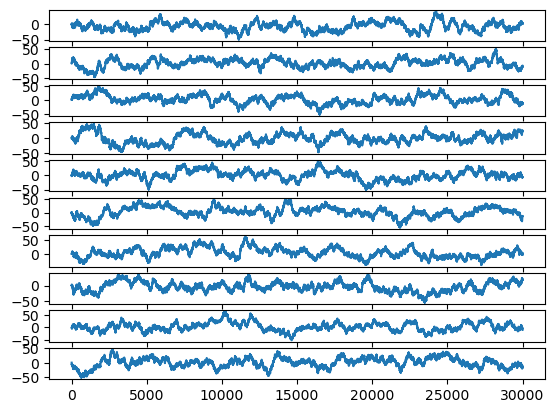

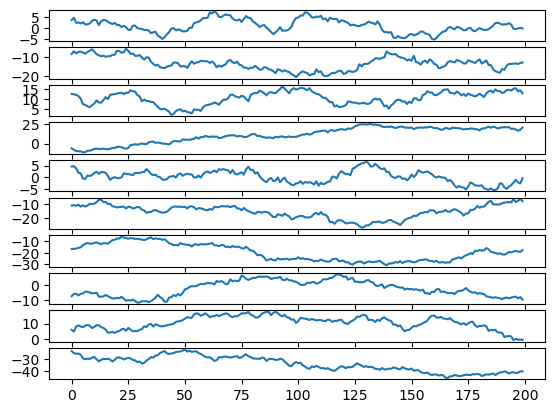

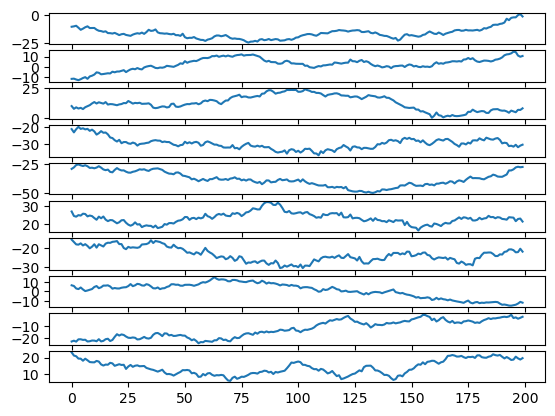

In [71]:
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][400:600])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])


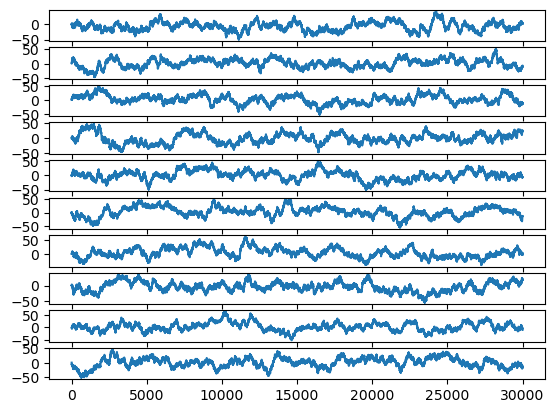

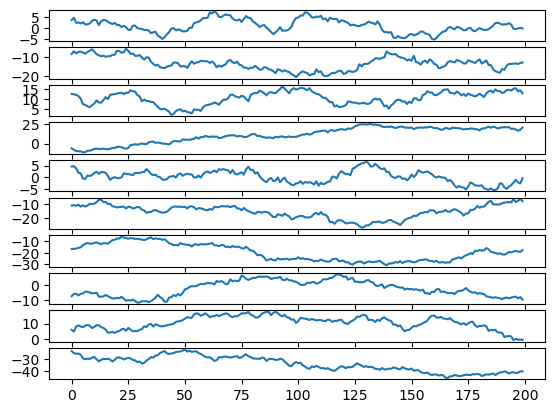

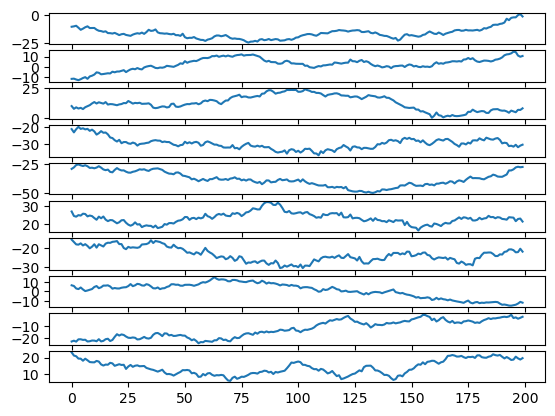

In [72]:
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][400:600])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])

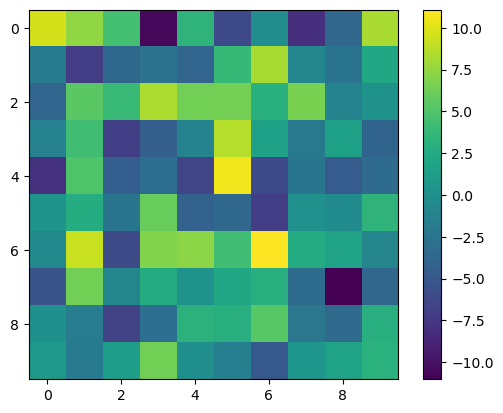

In [73]:
weight_matrix = simulator.W_ij

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

torch.Size([10, 30000])


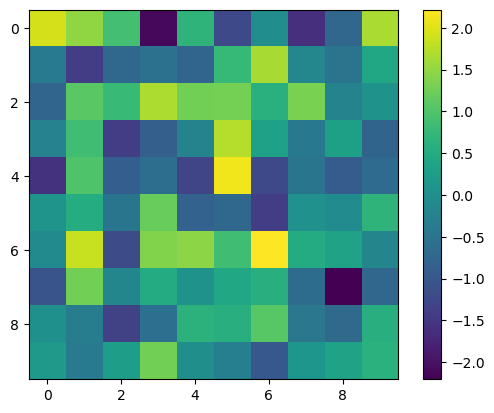

In [74]:
neuron_num = 10
dt = 0.001
tau = 0.3

spike_neuron_num=2
spike_input=5

random_seed=42
total_time = 30000

train_dataloader, val_dataloader, weight_matrix = generate_simulation_data(neuron_num=neuron_num, 
                                                    dt=dt, 
                                                    tau=tau, 
                                                    spike_neuron_num=spike_neuron_num, 
                                                    spike_input=spike_input,
                                                    random_seed=random_seed,
                                                    total_time=total_time)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

torch.Size([32, 10, 200])


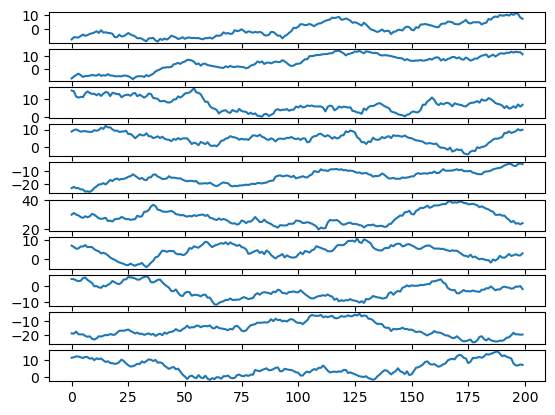

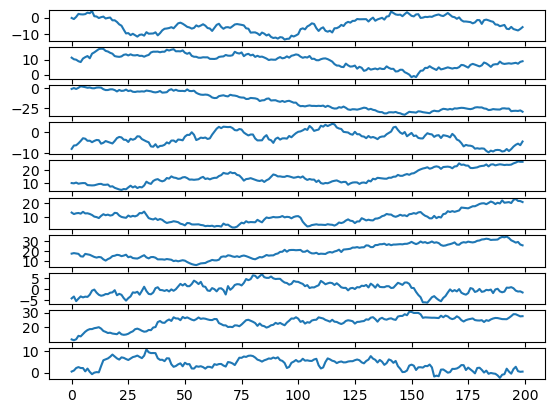

In [75]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(sample_batched[0].shape)
    samples = sample_batched[0][0:2]
    for i in range(neuron_num):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[0][i])
    plt.show()
    for i in range(neuron_num):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[1][i])
    plt.show()
    break